In [1]:
import torch
import pandas as pd
import sklearn.model_selection # train_test_split
import sklearn.metrics  #  confusion_matrix  accuracy_score


data = pd.read_csv(r"C:\Users\rvell\Desktop\Coding\Diabetes\Data\diabetes.csv")

X = data.drop('Outcome' , axis = 1) #independent Feature

### droping all features that i dont want in my Dataloader

#X = X.drop('Pregnancies' , axis = 1)
#X = X.drop('BloodPressure' , axis = 1)
#X = X.drop('Age' , axis = 1)
#X = X.drop('SkinThickness' , axis = 1)
#X = X.drop('Glucose' , axis = 1)
#X = X.drop('Insulin' , axis = 1)
y = data["Outcome"]

inputFeatures = 8 #
num_epochs = 5
batch_size =4

train_shuffele =False

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y , test_size =0.2,random_state=0)

#convert them to tensors
X_train=torch.FloatTensor(X_train.values)
X_test=torch.FloatTensor(X_test.values)
y_train=torch.LongTensor(y_train.values)
y_test=torch.LongTensor(y_test.values)

#X_train.requires_grad = True
#y_train.requires_grad = True
#X_test.requires_grad = True
#y_test.requires_grad = True

In [2]:


trainset = list(zip(X_train , y_train))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=train_shuffele , num_workers=2)

testset = list(zip(X_test , y_test))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Net(nn.Module):
    def __init__(self,input_features=inputFeatures,hidden1=10, hidden2=5,out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features,hidden1)
        self.f_connected2 = nn.Linear(hidden1,hidden2)
        self.out = nn.Linear(hidden2,out_features)
        
    def forward(self,x):
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x


In [5]:
#torch.manual_seed(20)
model = Net()
model.parameters

<bound method Module.parameters of Net(
  (f_connected1): Linear(in_features=8, out_features=10, bias=True)
  (f_connected2): Linear(in_features=10, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)>

In [6]:
# Backward Propergation - loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01) # 0.01


In [7]:

device ="cpu" #cpu is faster
#device = "cuda:0" if torch.cuda.is_available() else "cpu"

final_losses=[]
grads = [] 

epoch_final_losses = []
loss = 0
for epoch in range(num_epochs):
    epoch_final_losses.append(loss)

    for inputs, labels in trainloader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs.requires_grad = True
           
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            final_losses.append(loss.cpu())
            _, preds = torch.max(outputs, 1)
            
            # backward
            loss.backward()

            grads.append(inputs.grad)
            optimizer.step()



2023-01-13_132039
./Results/Num_Epochs_5batchSize_42023-01-13_132039/


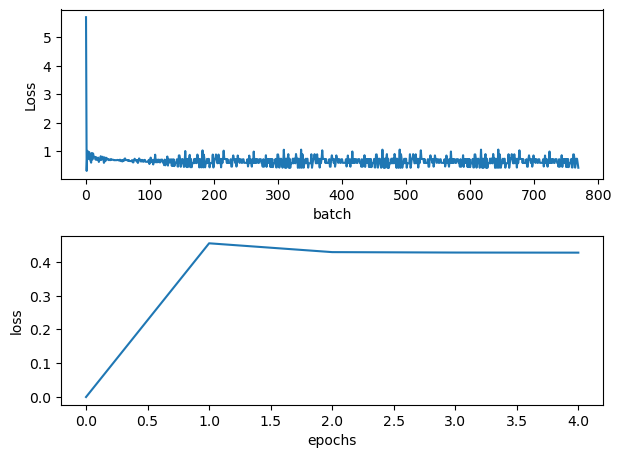

In [8]:
from matplotlib import pyplot as plt
#plot the loss function
from datetime import date , datetime
import os

# datetime now to name results
datetimeNow =str(date.today()) + str(datetime.now().strftime("_%H%M%S"))
print(datetimeNow)

 #dir_Path
path = './Results/'+  'Num_Epochs_' + str(num_epochs) +'batchSize_'+ str(batch_size)+ str(datetimeNow) +"/"
print(path)

isExist = os.path.exists(path)

if not isExist:
    os.makedirs(path)
with torch.no_grad():

    fig, axs = plt.subplots(2)

    fig.tight_layout(pad=2.0)
    axs[0].plot(range(len(final_losses)),final_losses)
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('batch')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('loss')
    axs[1].plot(range(len(epoch_final_losses)),epoch_final_losses)

    fig.savefig(str(path) + "_loss")



    

In [9]:
predictions = []

# if was on cuda , put back to cpu 
X_test= X_test.to("cpu")

with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())


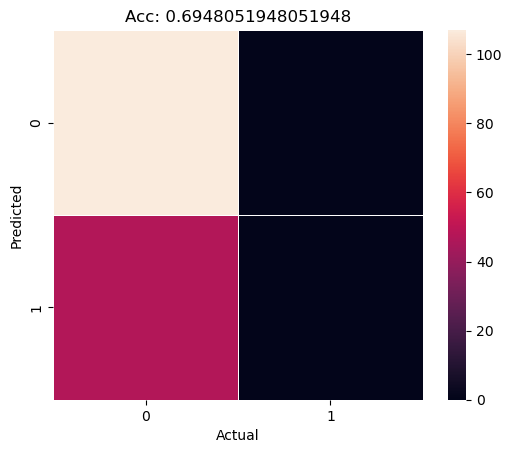

In [10]:
cm = sklearn.metrics.confusion_matrix(y_test,predictions)
cm
plt.imshow(cm, cmap='hot', interpolation='nearest')

import seaborn as sns
ax = sns.heatmap(cm, linewidth=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Acc: ' + str(sklearn.metrics.accuracy_score(y_test , predictions)))
plt.savefig(str(path) + "_TrueFalseHeatmap")
plt.show()

[]


[]

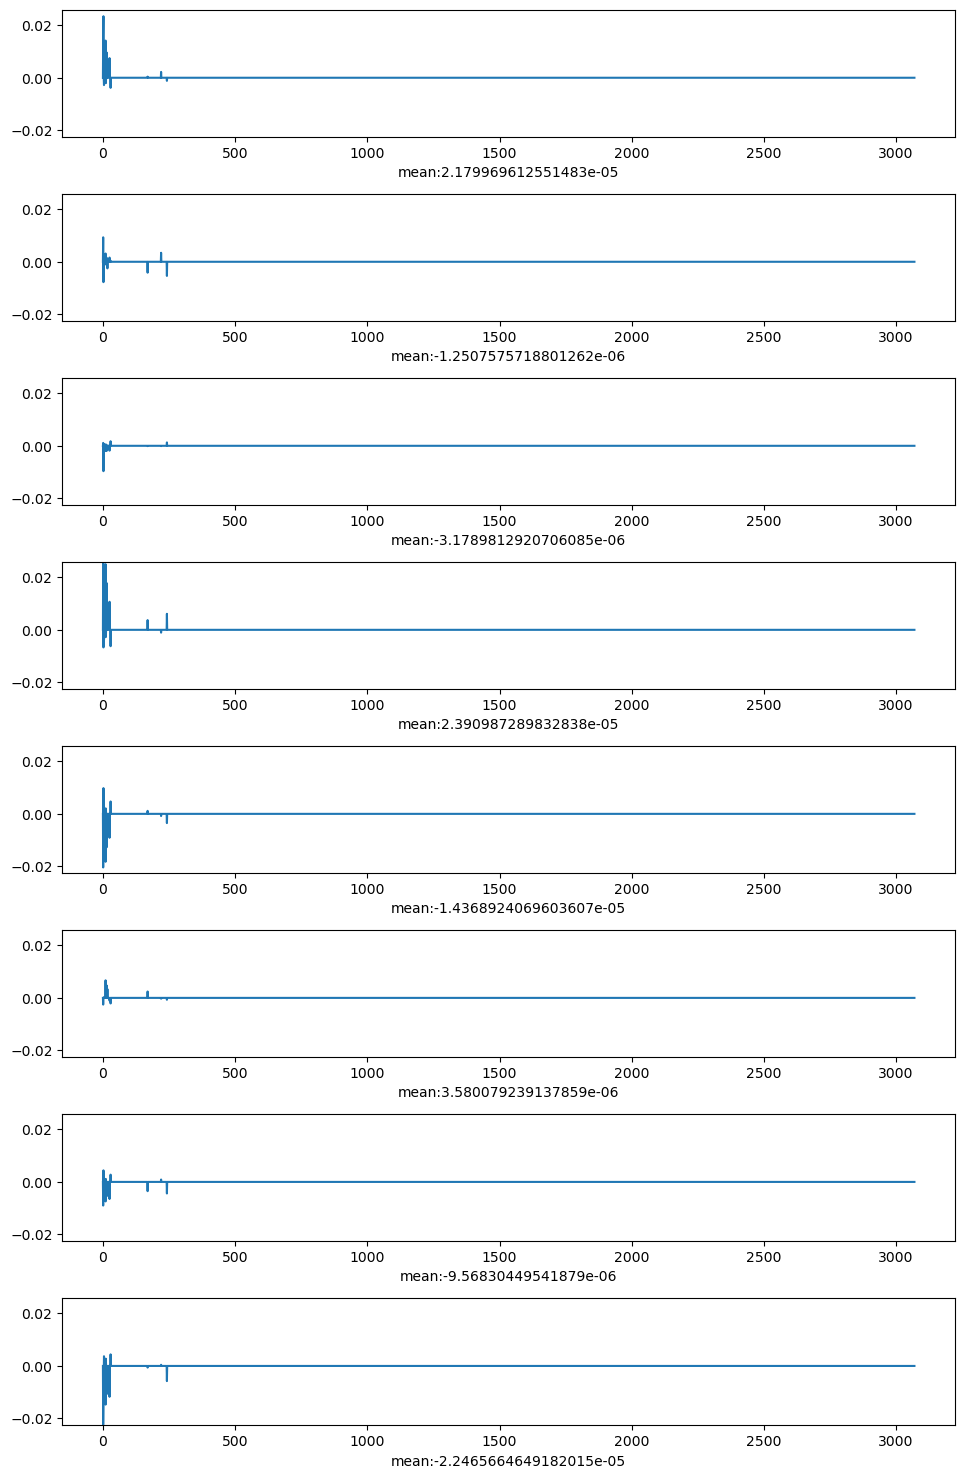

In [11]:
import numpy as np


featureListALL = []

for i in range(inputFeatures):
    featureListALL.append([])

print(featureListALL[1])
for i in range(len(grads)):
    for j in range(len(grads[i])):
        for k in range(inputFeatures):
            featureListALL[k].append(grads[i][j][k].item())

#save data as .npz according to datatime now

#TODO:
# Sava also different metrics accuracy , mean, 
# maybe accuracy over time 
# plot the gradients for every image over time 
#

##### add batch size and model structure 

#makeDir for all plotted things


np.savez(str(path) + 'featureListALL.npz', featureListALL = featureListALL)


#load data according to datatime now same as above since same datetimeNow
data = np.load(str(path) + 'featureListALL.npz')


featureListALL = data["featureListALL"]



fig, axs = plt.subplots(inputFeatures)

fig.set_size_inches(10,15)
fig.tight_layout(pad=2.0)
#find maximum/minumum 

maxValue = -1
minValue = 1
#calculate metrics
gradientMean_Features = []
for i in range(len(featureListALL)):
    gradientMean_Features.append(featureListALL[i].mean())

    maxValue = max( maxValue, max( featureListALL[i]))    
    minValue = min( minValue, min(featureListALL[i]))

#plot for all features
for i in range(len(axs)):
    axs[i].set_ylim(minValue,maxValue)
    axs[i].set_xlabel("mean:" + str(gradientMean_Features[i]))
    axs[i].plot(featureListALL[i])

plt.savefig(str(path) +"featureListALL" )
plt.plot()
